In [18]:
import numpy as np
from basis_expansions import Binner, Polynomial
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [20]:
x = np.random.uniform(size=100)

def signal(x):
    return (x*x*x*(x-1) 
            + 2*(1/(1 + np.exp(-0.5*(x - 0.5)))) 
            - 3.5*(x > 0.2)*(x < 0.5)*(x - 0.2)*(x - 0.5)
            - 0.95)

y = signal(x) + np.random.normal(scale=0.05, size=100)

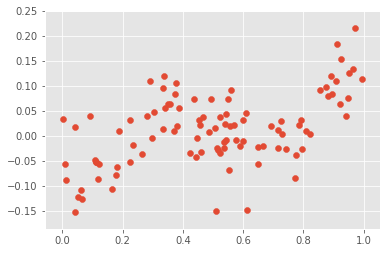

In [21]:
plt.scatter(x, y)

# Binned regression with dummy varaibles.

In [22]:
regressions = {}
for n_bins in range(2, 25):
    regressions[n_bins] = Pipeline([
        ('binner', Binner(0, 1, n_bins=n_bins)),
        ('regression', LinearRegression(fit_intercept=False))
    ])
    regressions[n_bins].fit(x, y)

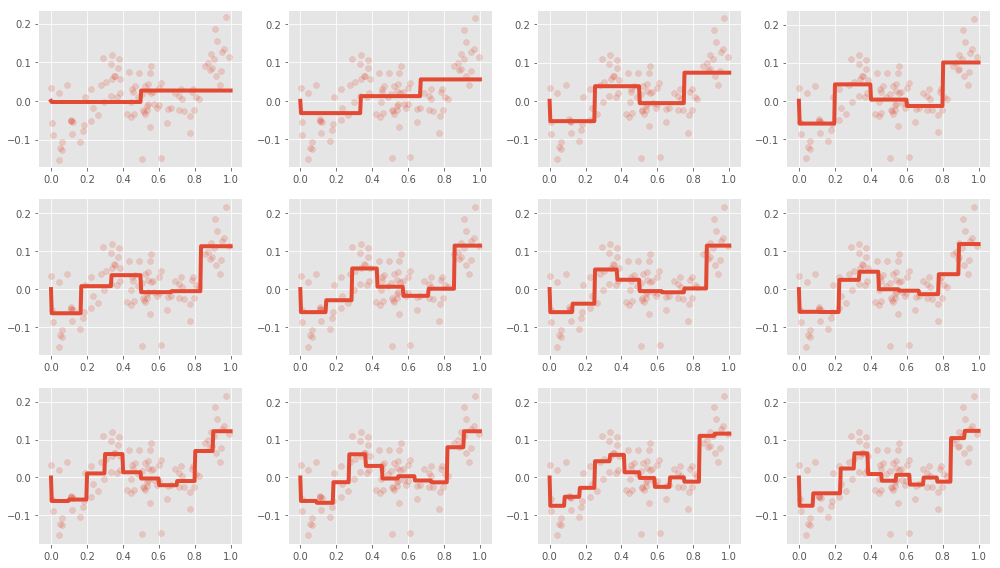

In [23]:
fig, ax = plt.subplots(3, 4, figsize=(14, 8))

t = np.linspace(0, 1, 250)
for i, ax in enumerate(ax.flatten()):
    n_bins = i + 4
    ax.plot(t, regressions[n_bins].predict(t), linewidth=4)
    ax.scatter(x, y, alpha=0.2)
    
fig.tight_layout()

# Binned regression with polynomial expansion

In [24]:
regressions = {}
for degree in range(1, 24):
    regressions[degree] = Pipeline([
        ('std', StandardScaler()),
        ('binner', Polynomial(degree=degree)),
        ('regression', LinearRegression(fit_intercept=True))
    ])
    regressions[degree].fit(x.reshape(-1, 1), y)

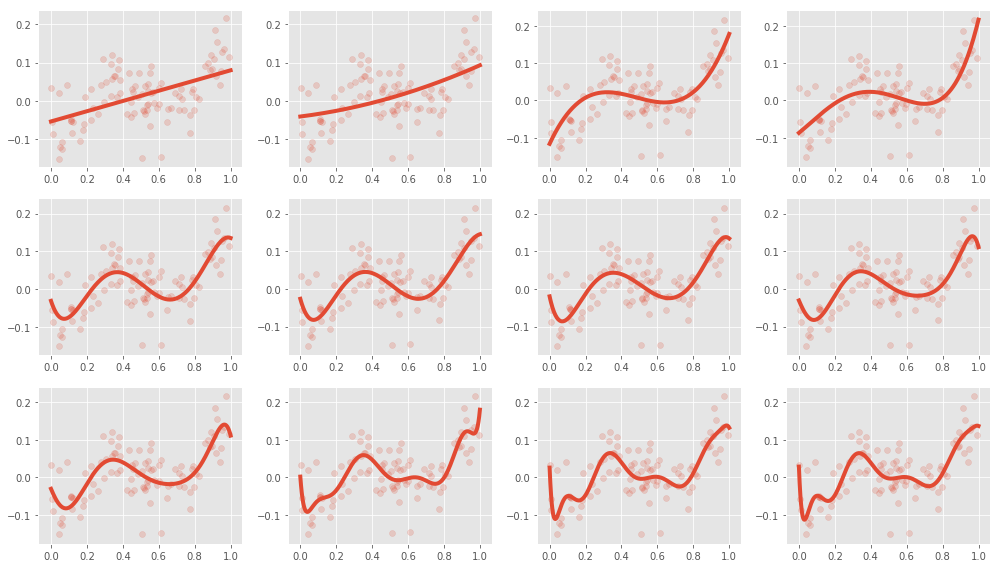

In [25]:
fig, ax = plt.subplots(3, 4, figsize=(14, 8))

t = np.linspace(0, 1, 250)
for i, ax in enumerate(ax.flatten()):
    degree = i + 1
    ax.plot(t, regressions[degree].predict(t.reshape(-1, 1)), linewidth=4)
    ax.scatter(x, y, alpha=0.2)
    
fig.tight_layout()